# EDA

**Imports**

In [1]:
# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# data separation/transformation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# system manipulation
import itertools
import os
import sys
sys.path.append("./util_")
import prepare_
import explore_

# other
import env
import warnings
warnings.filterwarnings("ignore")

# set the random seed
np.random.seed(95)

**get data**

In [2]:
# This data is already been split and save
# This is only training data
train = pd.read_csv("./00_project_data/01_original_clean_no_dummies_train.csv", index_col=0)
train = train.reset_index(drop=True)
train.head()

,bedrooms,bathrooms,sqr_feet,tax_value,year_built,tax_amount,county
0,3,3.0,1601.0,160657.0,1947,3259.81,Los Angeles
1,3,1.0,980.0,243277.0,1952,2905.82,Orange
2,3,3.0,2060.0,285312.0,1957,3497.72,Los Angeles
3,3,2.0,1307.0,268523.0,1982,2960.60,Ventura
4,3,2.0,1915.0,339115.0,1976,4356.32,Los Angeles


## Univariate statistics

In [3]:
# Discdescribetive statistics
train.describe()

,bedrooms,bathrooms,sqr_feet,tax_value,year_built,tax_amount
count,1.237902e+06,1.237902e+06,1.237902e+06,1.237902e+06,1.237902e+06,1.237902e+06
mean,3.265254e+00,2.163884e+00,1.773119e+03,3.868591e+05,1.960517e+03,4.767382e+03
std,8.925742e-01,8.495845e-01,7.319210e+02,2.883380e+05,2.160527e+01,3.314226e+03
min,0.000000e+00,0.000000e+00,1.000000e+00,2.200000e+01,1.900000e+03,1.344000e+01
25%,3.000000e+00,2.000000e+00,1.248000e+03,1.851815e+05,1.949000e+03,2.496622e+03
50%,3.000000e+00,2.000000e+00,1.602000e+03,3.195240e+05,1.958000e+03,4.013095e+03
75%,4.000000e+00,3.000000e+00,2.141000e+03,5.083028e+05,1.974000e+03,6.120360e+03
max,7.000000e+00,7.000000e+00,5.000000e+03,4.060999e+06,2.016000e+03,1.999984e+04


In [4]:
# look at the number of unique categories
train.nunique()

bedrooms           8
bathrooms         16
sqr_feet        4802
tax_value     418413
year_built       117
tax_amount    670451
county             3
dtype: int64

In [5]:
# find only columns with low count of categories
low_category_cols = train.nunique()[train.nunique() < 1000].index
low_category_cols

Index(['bedrooms', 'bathrooms', 'year_built', 'county'], dtype='object')

In [6]:
def plot_categorical_and_continuous_vars():
    # plot all the low category columns to see the distributions
    for col in low_category_cols:
        print(col.upper())
        print("count of unique:",train[col].nunique())
        print(train[col].value_counts().sort_values(), train[col].value_counts(normalize=True).sort_values())

        # plot
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(17,4))
        sns.countplot(data= train, x=col, ax=ax[0])
        sns.boxplot(data= train, x=col, ax=ax[1])
        sns.violinplot(data= train, x=col, ax=ax[2])
        plt.tight_layout()

        # save visual to file path
        explore_.save_visuals(fig=fig, viz_name=col, folder_name= 1)

        plt.show()

In [7]:
# plot_categorical_and_continuous_vars()

**Univariate for other continuous variables**

SQR_FEET
count of unique: 4802


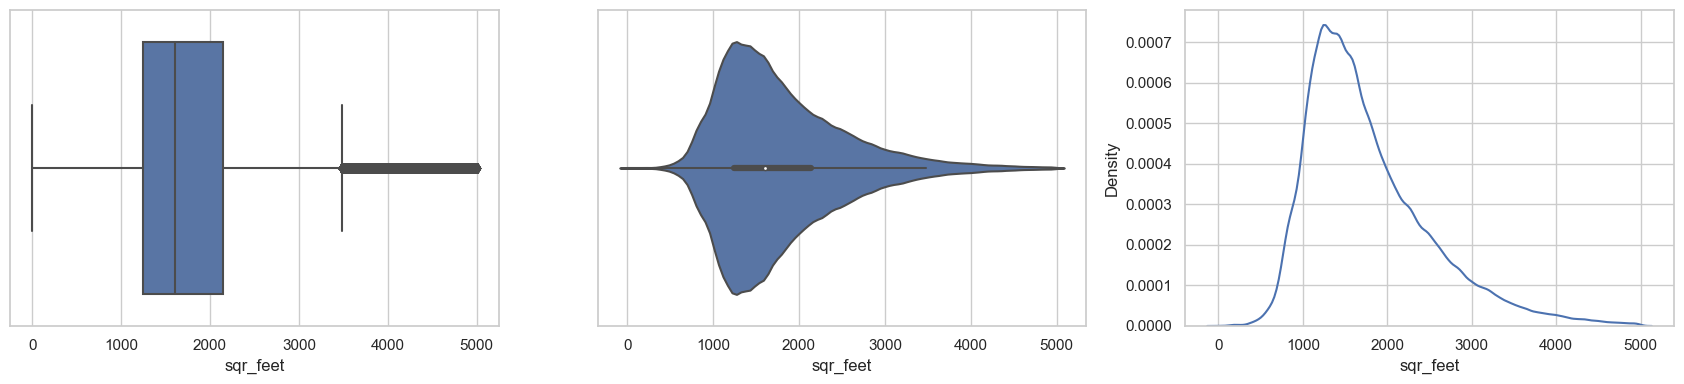

TAX_VALUE
count of unique: 418413


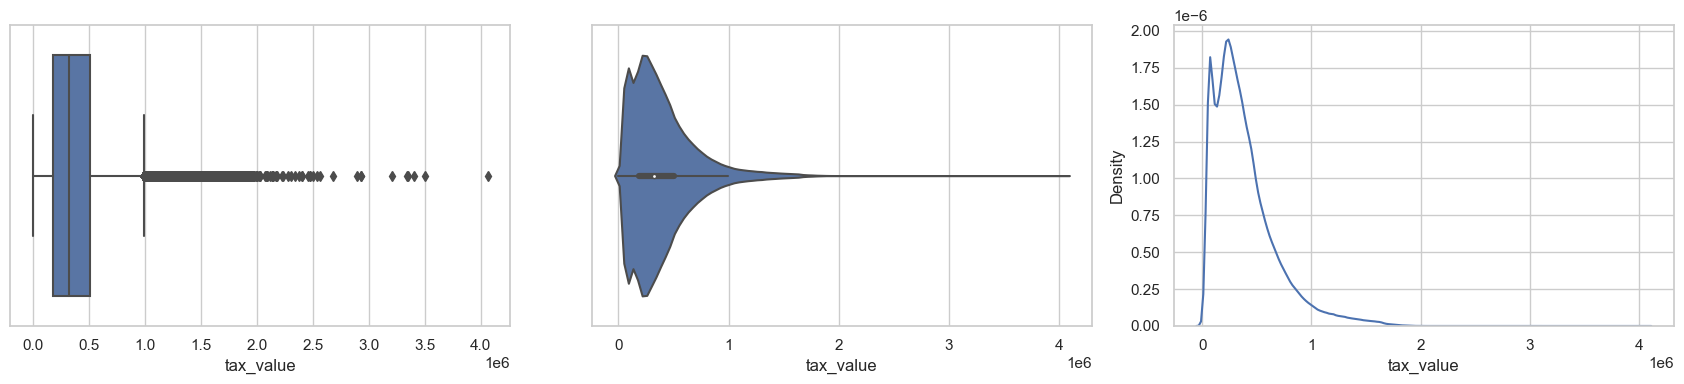

TAX_AMOUNT
count of unique: 670451


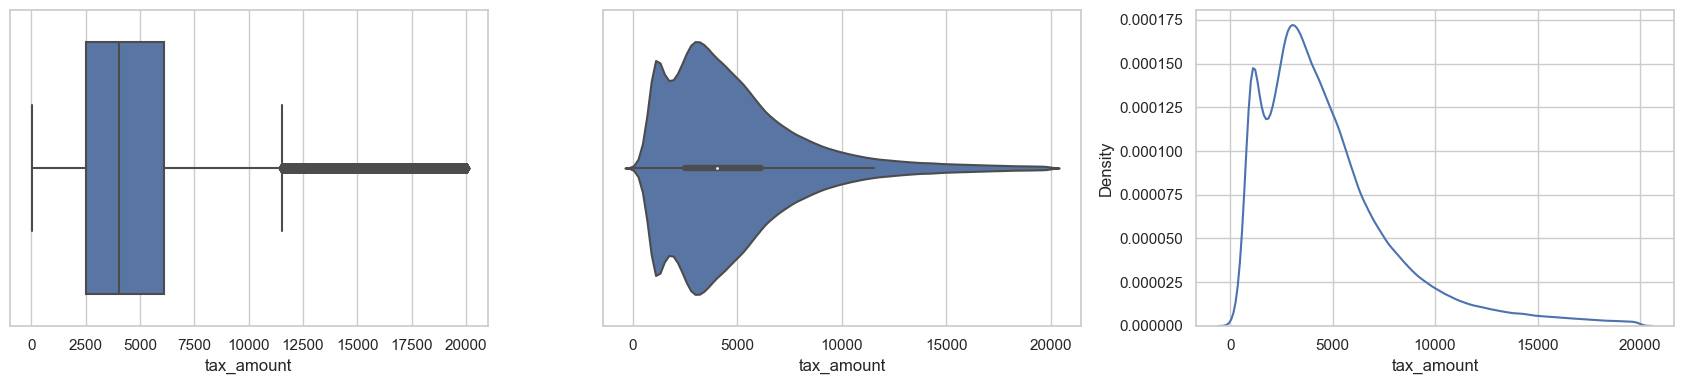

In [8]:
# # Get a sample of the continious columns to fro ploting
train_continious = train[["sqr_feet", "tax_value", "tax_amount"]]

# plot all the low category columns to see the distributions
for col in train_continious.columns:
    print(col.upper())
    print("count of unique:",train[col].nunique())
    # plot
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(17,4))
    sns.boxplot(data= train, x=col, ax=ax[0])
    sns.violinplot(data= train, x=col, ax=ax[1])
    sns.kdeplot(train, x=col, ax=ax[2])
    plt.tight_layout()
    
    # save visual to file path
    explore_.save_visuals(fig=fig, viz_name=col, folder_name= 1)

    plt.show()

**Take aways**
- `bathrooms` and `bedrooms`: looks to have some normality with some outliers.

- `county`: three categories with Los Angeles having the largest porpotion.
- `sqr_feet`: positive skew (right skew) with out liers starting at aout 3500 sqr feet.
- `tax_amount`: bimodal distribution with two picks (modes) and contains outliers starting at about 12000 dollars.
- `tax_value`: bimodal distribution with two picks (modes) and contains outliers starting at about 100000 dollars. (this may be do to the `0` values in bedroom and bathrooms)
- `year built`: have some normality shape to it and some outliers . its pick is aroung the 1955.

## Bivariate statistics

In [9]:
# separeate discrete from continuous variables
continuous_col = []
categorical_col = []
target = "tax_value"

for col in train.columns:
    if col == target:
        pass
    elif train[col].dtype == "O":
        categorical_col.append(col)

    else:
        if len(train[col].unique()) < 20: #making anything with less than 4 unique values a catergorical value
            categorical_col.append(col)
        else:
            continuous_col.append(col)
            
categorical_col, continuous_col

(['bedrooms', 'bathrooms', 'county'], ['sqr_feet', 'year_built', 'tax_amount'])

**categorical variables**

In [10]:
# Get a sample of the categorical columns for ploting
train_continious = train[categorical_col].sample(100_000)

# pairs of comninmations
categorical_comb = list(itertools.product(categorical_col, ["tax_value"]))
categorical_comb

[('bedrooms', 'tax_value'),
 ('bathrooms', 'tax_value'),
 ('county', 'tax_value')]

BEDROOMS VS TAX_VALUE


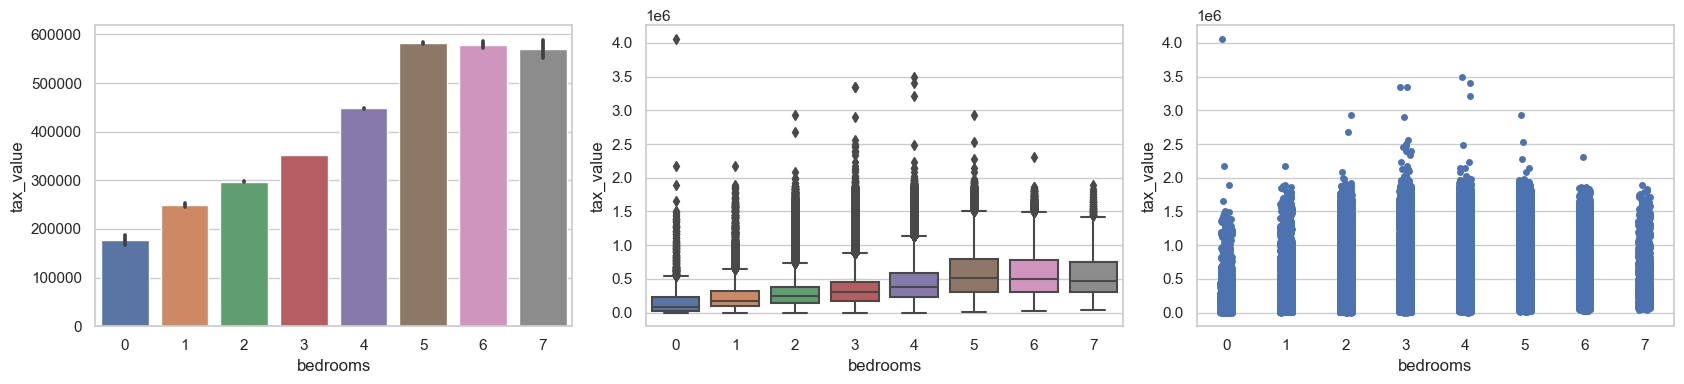

BATHROOMS VS TAX_VALUE


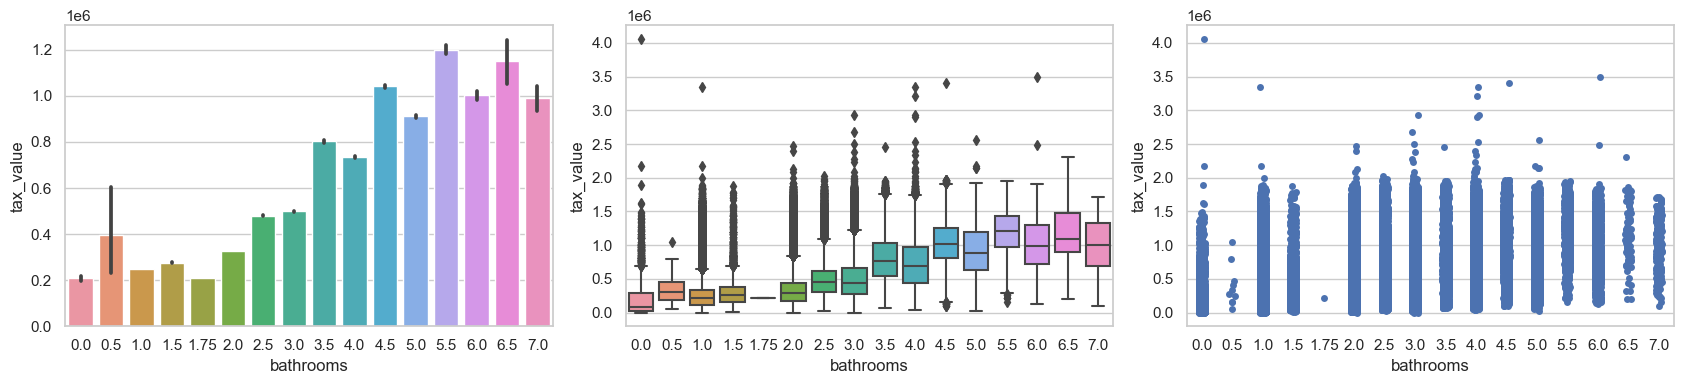

COUNTY VS TAX_VALUE


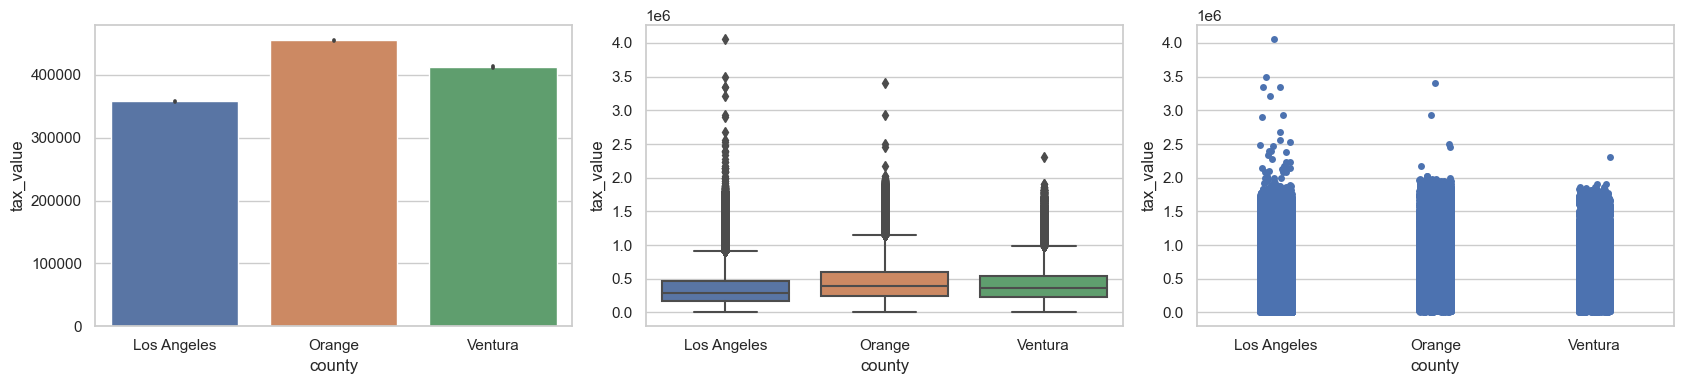

In [11]:
# Get a sample of the continious columns to fro ploting
train_full_sample = train[train.columns].sample(100_000)

# plot all the low category columns to see the distributions
for col in categorical_comb:
    print(col[0].upper(), "VS", col[1].upper())
    # plot
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(17,4))
    sns.barplot(data= train, x=col[0] , y=col[1], ax= ax[0])
    sns.boxplot(data= train, x=col[0] , y=col[1], ax= ax[1])
    sns.stripplot(data= train, x=col[0] , y=col[1], ax= ax[2])
    plt.tight_layout()
    
    # save visual to file path
    explore_.save_visuals(fig=fig, viz_name=f"{col[0]}_vs_{col[1]}", folder_name= 2)
    
    plt.show()


**Take aways**
- `bathrooms_vs_tax_value`: `0` bathrooms has the lowest average while `5.5` have the highers average. `5 and 6` bathroom counts have the higers tax value.
- `bedrooms_vs_tax_value`: `0` bedrooms has the lowest average while `5` have the highers average.`5, 6and 7` bedroom counts have the higers tax value.
- `county_vs_tax_value`: `orange county` have a sighly higer average than the other counties but it's not by much. outliers might be affecting these counties. `Orange county` have the higers tax value.

**Continuous variables**

In [12]:
# Get a sample of the categorical columns for ploting
train_continious = train[continuous_col].sample(50_000)

# pairs of comninmations
continuous_comb = list(itertools.product(continuous_col, ["tax_value"]))
continuous_comb

[('sqr_feet', 'tax_value'),
 ('year_built', 'tax_value'),
 ('tax_amount', 'tax_value')]

SQR_FEET VS TAX_VALUE


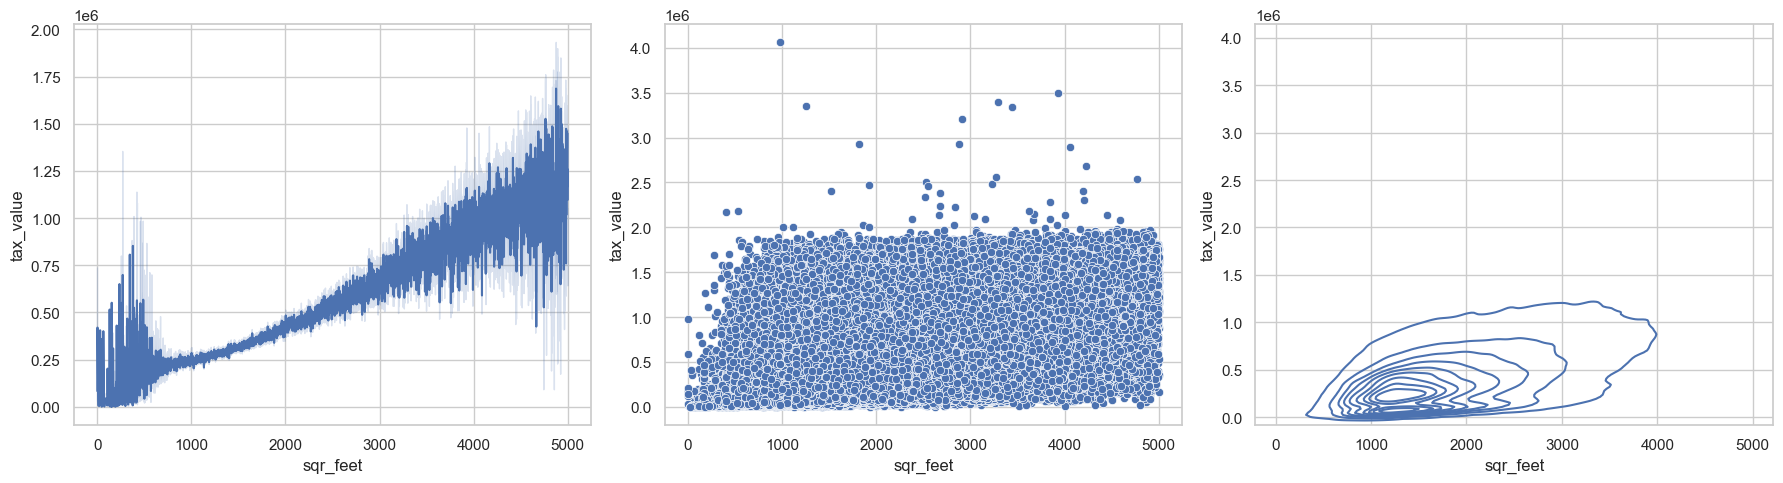

YEAR_BUILT VS TAX_VALUE


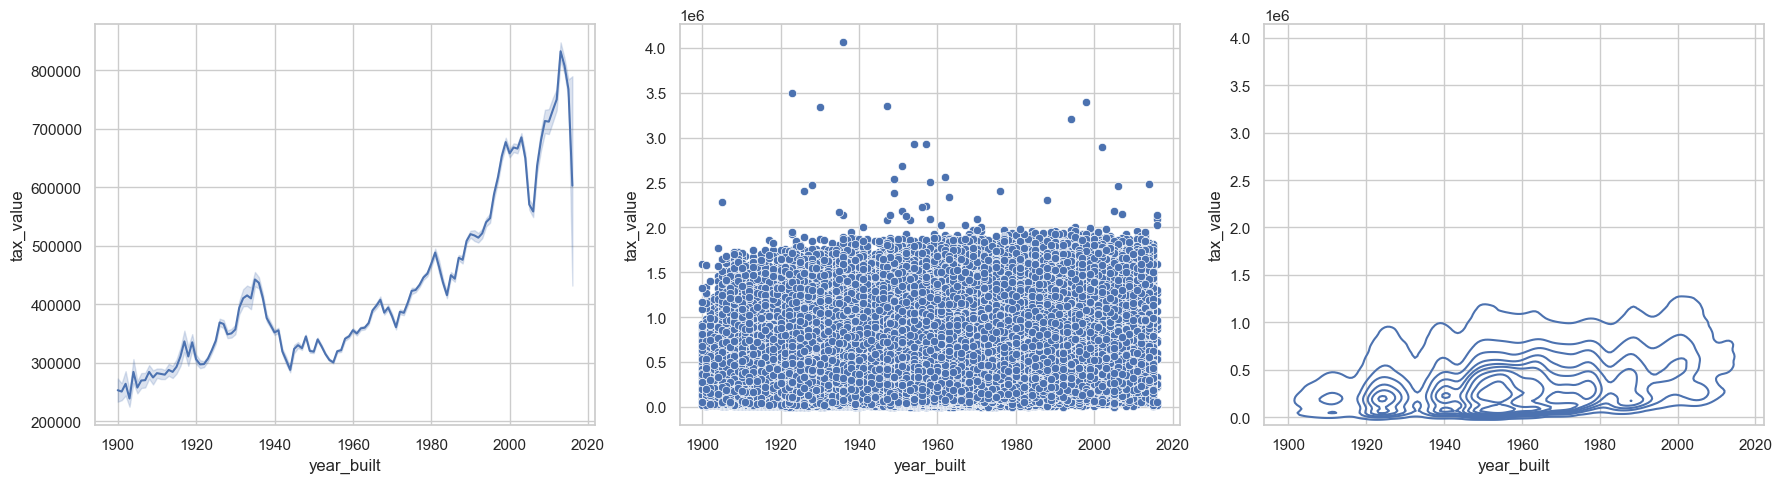

TAX_AMOUNT VS TAX_VALUE


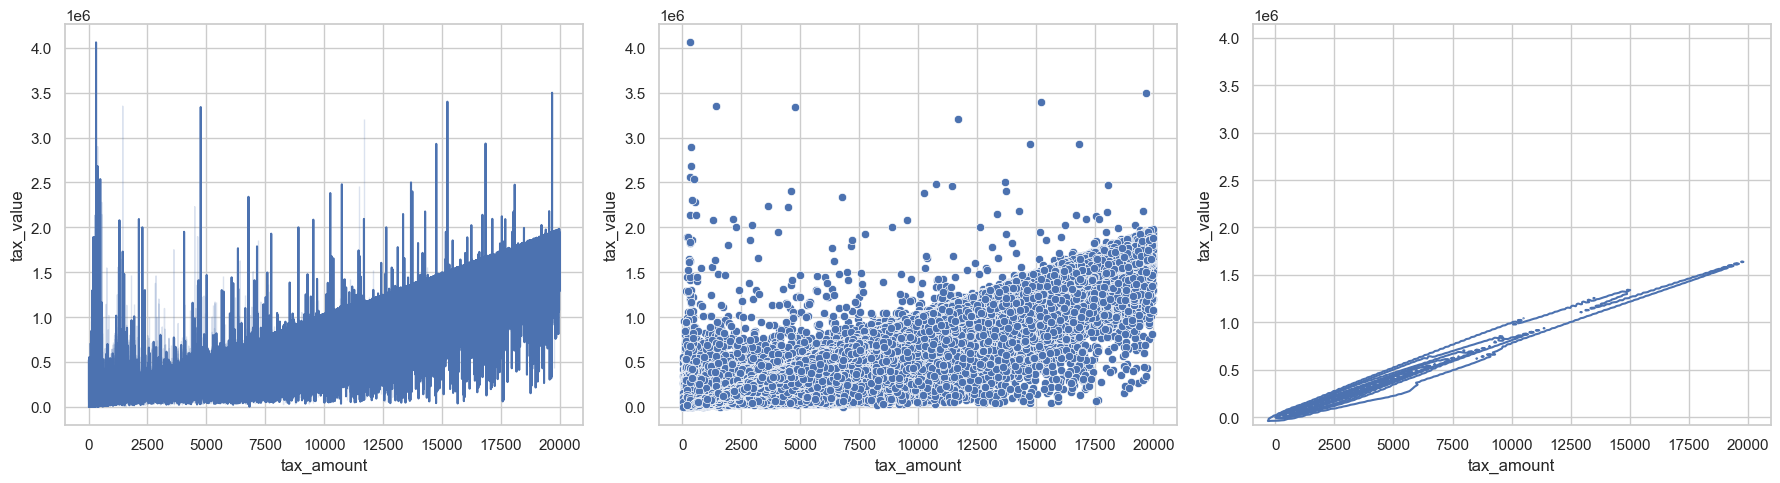

In [13]:
# plot all the low category columns to see the distributions

for col in continuous_comb:
    print(col[0].upper(), "VS", col[1].upper())
    # plots
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,5))   

    sns.lineplot(data= train, x=col[0] , y=col[1], ax= ax[0])
    sns.scatterplot(data= train, x=col[0] , y=col[1], ax= ax[1])
    sns.kdeplot(data= train, x=col[0] , y=col[1], ax= ax[2])
    
    plt.tight_layout()
    
    # save visual to file path
    explore_.save_visuals(fig=fig, viz_name=f"{col[0]}_vs_{col[1]}", folder_name= 2)
    
    plt.show()


**Take aways**
- `sqr_feet_vs_tax_value`: looks like a strong positive linear relationship between these two, but it is lossing the strength as it gains more sqare footage. this relationship looke to be strongest around 1500 sqr feet.
- `tax_amount_vs_tax_value`: looks like a moderate positive linear relationship between these two, but it is lossing the strength as it gains more dollars. this relationship looke to be strongest around 2500 dollars.
- `year)built_vs_tax_value`: looks like a positive linear relationship between these two. This relationship looke to be strongest around 1950 but countain miltiple little picks.

## Multivariate statistics

In [14]:
# get sample from training data
train_full_sample = train[train.columns].sample(100_000)
train_full_sample.head(2)

,bedrooms,bathrooms,sqr_feet,tax_value,year_built,tax_amount,county
872506,4,2.0,2207.0,281124.0,1958,3596.98,Orange
470731,3,2.0,2010.0,418471.0,1955,5002.33,Los Angeles


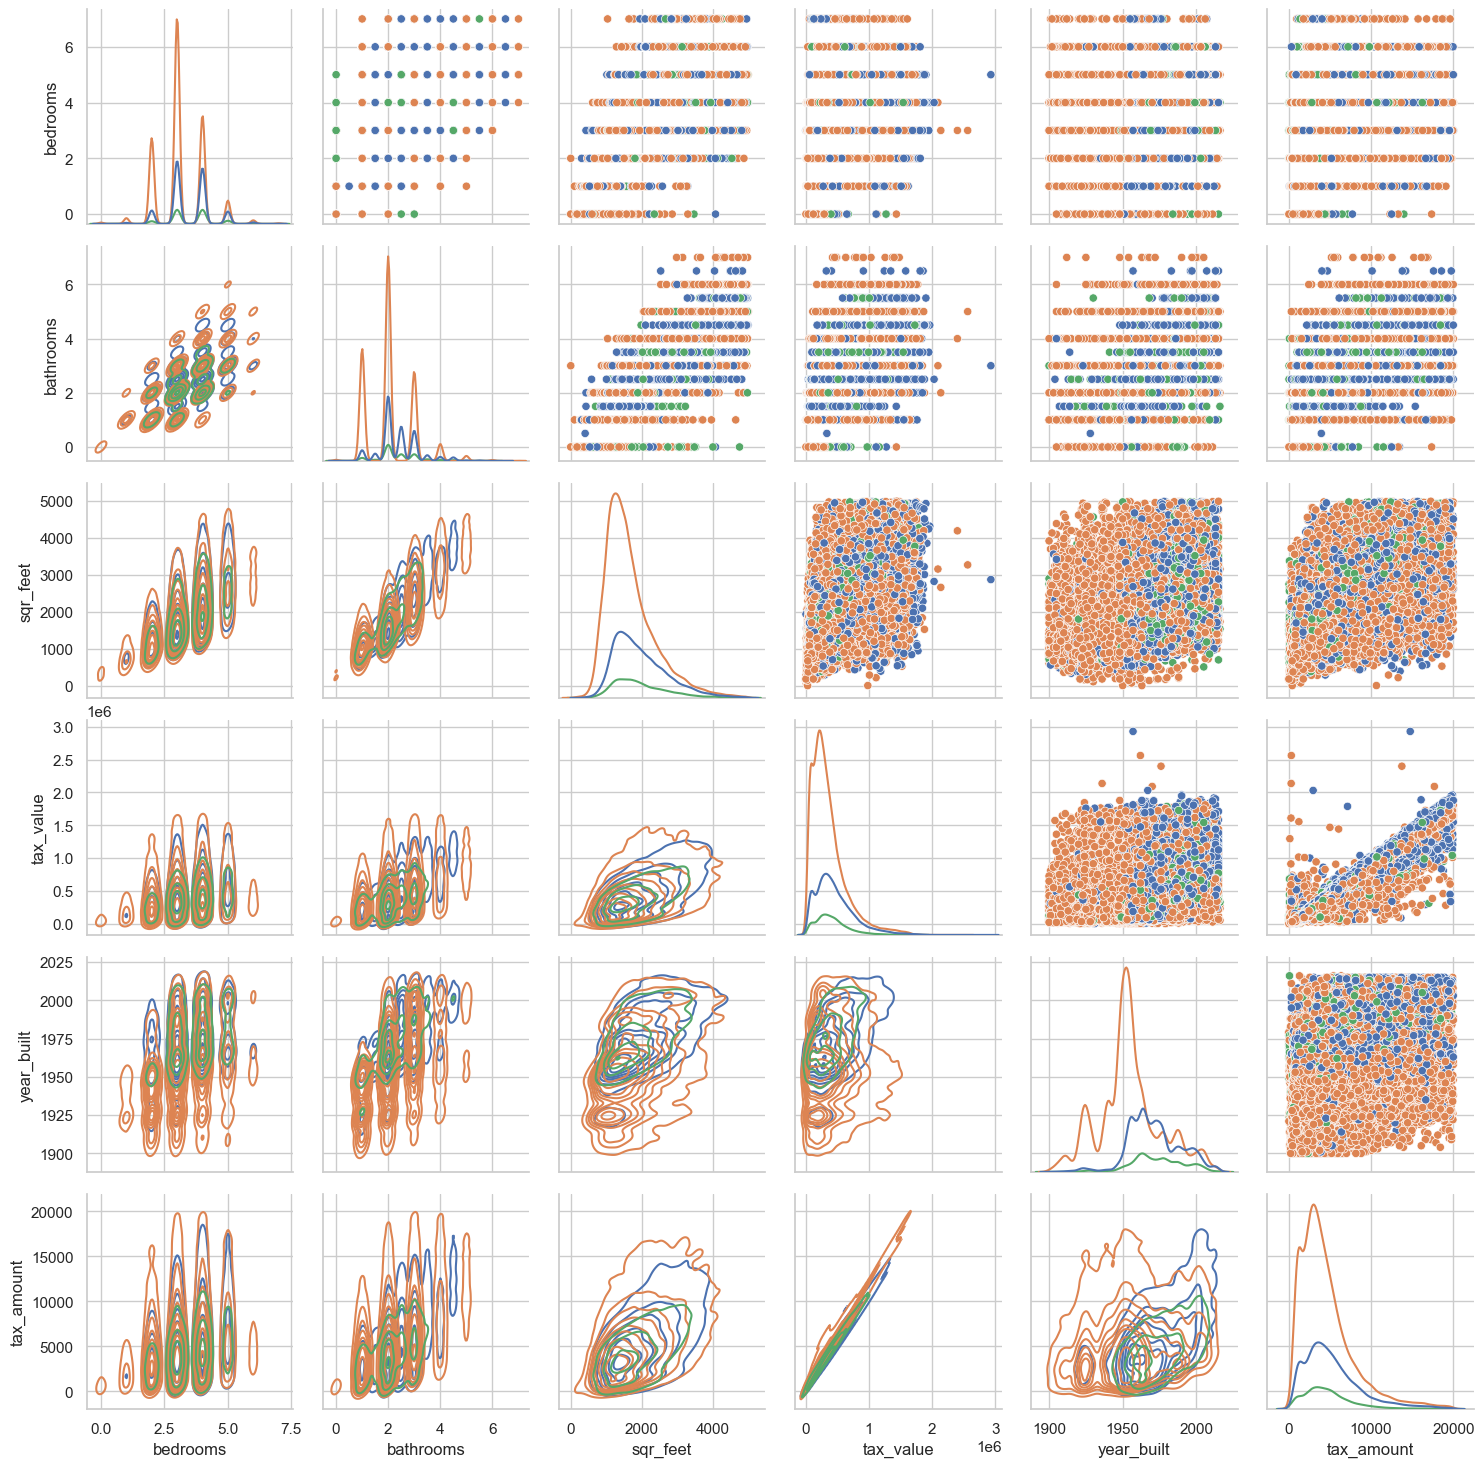

In [15]:
# plot
grid = sns.PairGrid(train_full_sample, diag_sharey=False, hue="county")
grid.map_upper(sns.scatterplot)
grid.map_lower(sns.kdeplot)
grid.map_diag(sns.kdeplot)

# Get the current figure
fig = plt.gcf()

# save visual to file path
explore_.save_visuals(fig=fig, viz_name= "pairplot_by_county", folder_name= 3)
plt.show()

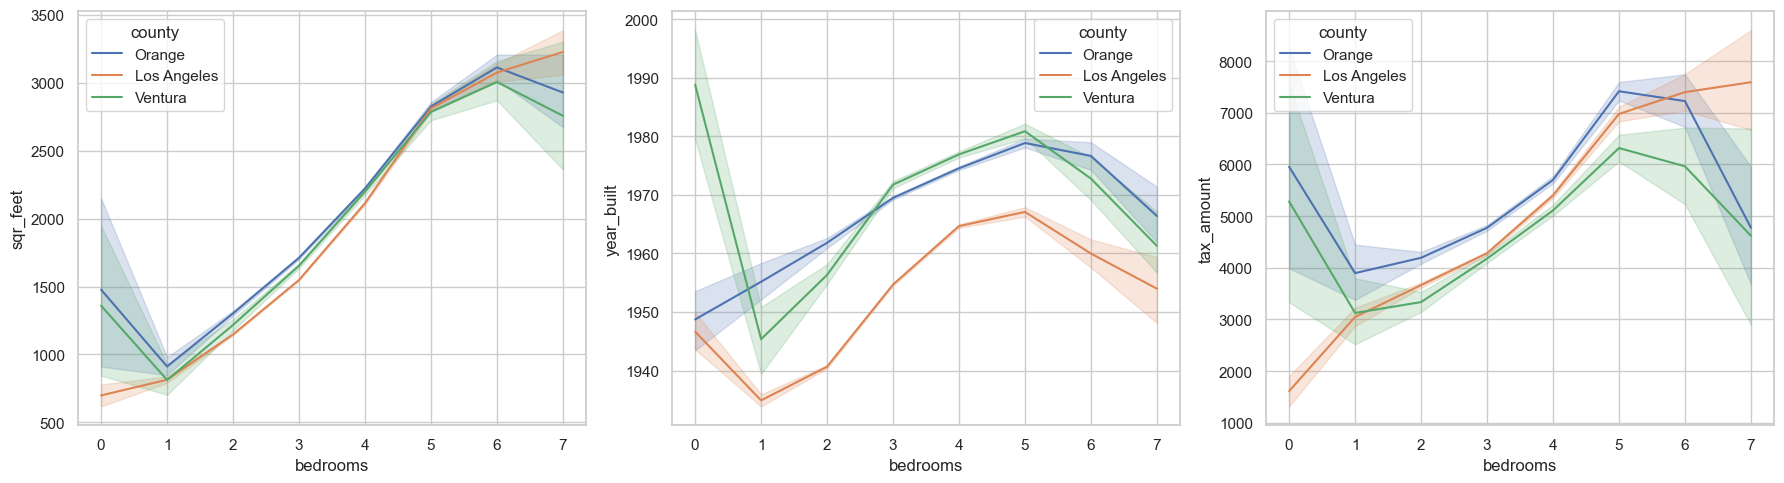

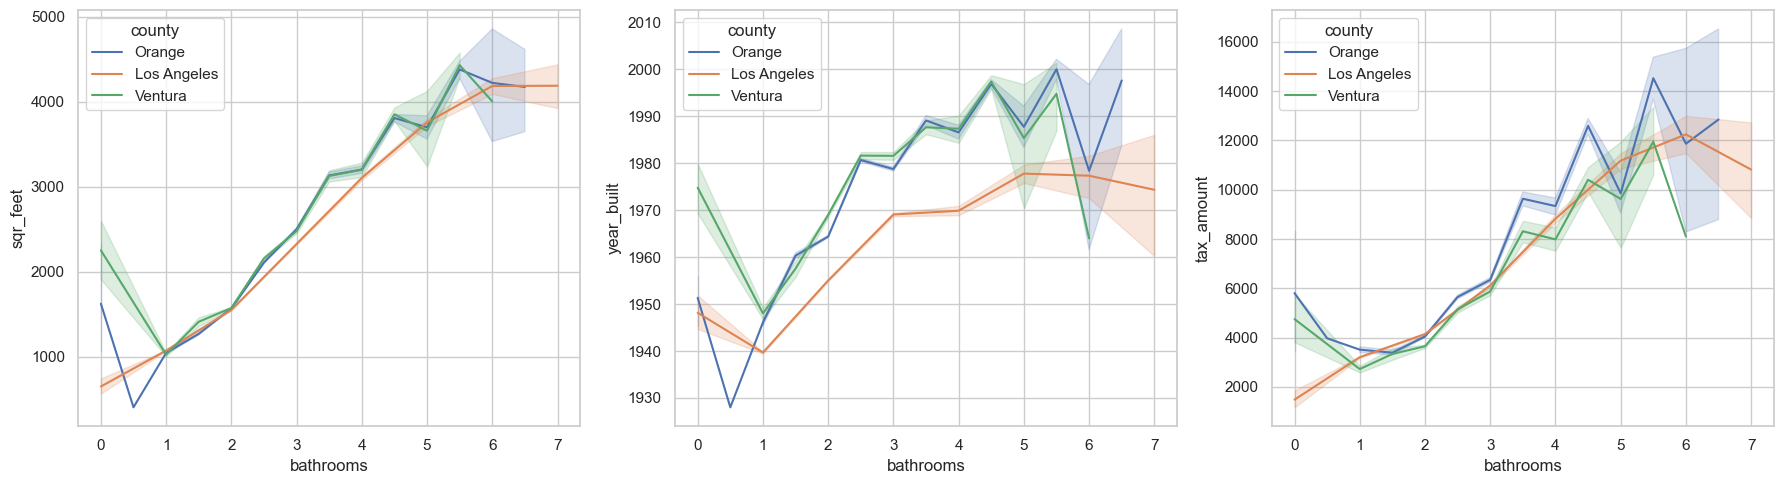

In [16]:
for cat in categorical_col[:-1]:
    # figure
    fig, ax = plt.subplots(nrows=1, ncols=len(continuous_col), figsize=(18,5))
    
    for i in range(len(continuous_col)):
        # plot
        sns.lineplot(data= train_full_sample, x= cat, y= continuous_col[i], hue="county", ax=ax[i])
        plt.tight_layout()
        
    # save visual
    explore_.save_visuals(fig=fig, viz_name=f"{cat}_vs_{continuous_col[i]}_by_county", folder_name= 3)
    plt.show
        